In [ ]:
import os
import json
import math
import random
from pathlib import Path
from typing import Dict, List, Sequence, Tuple

import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from tqdm.auto import tqdm

from huggingface_hub import hf_hub_download


In [ ]:
from torchvision import models
CLASS_NAMES = ["Scallop", "Roundfish", "Crab", "Whelk", "Skate", "Flatfish", "Eel"]

model = models.densenet121(num_classes=10)
in_features = model.classifier.in_features  # <-- include this before you redefine the head
model.classifier = nn.Linear(in_features, len(CLASS_NAMES))


In [ ]:
from pathlib import Path

PROJECT_ROOT = Path("/content/Marine_Learning")  # or the Windows path

IMAGE_DIR = PROJECT_ROOT / "data" / "data" / "classification_dataset" / "images"
MANIFEST_PATH = PROJECT_ROOT / "data" / "data" / "classification_dataset" / "labels.txt"
SPLIT_PATH = PROJECT_ROOT / "models" / "splits.json"

CLASS_NAMES = ["Scallop", "Roundfish", "Crab", "Whelk", "Skate", "Flatfish", "Eel"]
CLASS_TO_INDEX = {name.lower(): idx for idx, name in enumerate(CLASS_NAMES)}
SEED = 415
IMAGE_SIZE = 224
BATCH_SIZE = 16
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1


In [ ]:
import json
import random
from typing import Dict, List, Sequence, Tuple
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

def _load_manifest(manifest_path: Path, image_dir: Path) -> List[Tuple[str, int]]:
    if not manifest_path.exists():
        raise FileNotFoundError(f"Manifest missing at {manifest_path}")
    records: List[Tuple[str, int]] = []
    with manifest_path.open("r", encoding="utf-8") as handle:
        for line in handle:
            stripped = line.strip()
            if not stripped:
                continue
            filename, *label_parts = stripped.split()
            label_key = " ".join(label_parts).lower()
            label_idx = CLASS_TO_INDEX[label_key]
            image_path = image_dir / filename
            if not image_path.exists():
                raise FileNotFoundError(f"Missing image: {image_path}")
            records.append((str(image_path), label_idx))
    if not records:
        raise ValueError("Manifest contained no usable records.")
    return records

def _stratified_split(records: Sequence[Tuple[str, int]], train_ratio: float, val_ratio: float, seed: int):
    grouped: Dict[int, List[Tuple[str, int]]] = {}
    for path, label in records:
        grouped.setdefault(label, []).append((path, label))

    rng = random.Random(seed)
    splits = {"train": ([], []), "val": ([], []), "test": ([], [])}

    for label, items in grouped.items():
        rng.shuffle(items)
        total = len(items)
        train_count = max(1, round(total * train_ratio))
        val_count = max(1, round(total * val_ratio))
        if train_count + val_count >= total:
            val_count = max(1, total - train_count - 1)
        train_items = items[:train_count]
        val_items = items[train_count: train_count + val_count]
        test_items = items[train_count + val_count:]

        for split_name, subset in (("train", train_items), ("val", val_items), ("test", test_items)):
            paths, labels = splits[split_name]
            for path, lbl in subset:
                paths.append(path)
                labels.append(lbl)

    return splits

def load_or_create_splits(split_path: Path):
    records = _load_manifest(MANIFEST_PATH, IMAGE_DIR)
    if split_path.exists():
        with split_path.open("r", encoding="utf-8") as handle:
            saved = json.load(handle)
        filename_to_label = {Path(path).name: label for path, label in records}
        splits = {}
        for split_name, filenames in saved.items():
            paths = [str(IMAGE_DIR / name) for name in filenames]
            labels = [filename_to_label[Path(p).name] for p in paths]
            splits[split_name] = (paths, labels)
        return splits

    splits = _stratified_split(records, TRAIN_RATIO, VAL_RATIO, SEED)
    serializable = {name: [Path(path).name for path in paths] for name, (paths, _) in splits.items()}
    split_path.parent.mkdir(parents=True, exist_ok=True)
    with split_path.open("w", encoding="utf-8") as handle:
        json.dump(serializable, handle, indent=2)
    return splits


In [ ]:
class BenthicDataset(Dataset):
    def __init__(self, filepaths, labels, transform=None):
        self.filepaths = list(filepaths)
        self.labels = list(labels)
        self.transform = transform

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        image = Image.open(self.filepaths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

def build_transforms(image_size=224, random_erasing_p=0.5):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    train_transform = transforms.Compose([
        transforms.Resize(int(image_size * 1.2)),
        transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.15, contrast=0.15,
                               saturation=0.15, hue=0.05),
        transforms.ToTensor(),
        normalize,
        transforms.RandomErasing(p=random_erasing_p, scale=(0.02, 0.25),
                                 ratio=(0.3, 3.3), value="random"),
    ])
    eval_transform = transforms.Compose([
        transforms.Resize(int(image_size * 1.1)),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        normalize,
    ])
    return train_transform, eval_transform

def build_dataloaders(splits, image_size, batch_size):
    train_tfm, eval_tfm = build_transforms(image_size=image_size)
    train_files, train_labels = splits["train"]
    val_files, val_labels = splits["val"]
    test_files, test_labels = splits["test"]

    train_ds = BenthicDataset(train_files, train_labels, train_tfm)
    val_ds = BenthicDataset(val_files, val_labels, eval_tfm)
    test_ds = BenthicDataset(test_files, test_labels, eval_tfm)

    loader_kwargs = dict(batch_size=batch_size,
                         num_workers=0,
                         pin_memory=torch.cuda.is_available())
    return (
        DataLoader(train_ds, shuffle=True, **loader_kwargs),
        DataLoader(val_ds, shuffle=False, **loader_kwargs),
        DataLoader(test_ds, shuffle=False, **loader_kwargs),
    )


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

root = Path("/content/drive/MyDrive/Colab Notebooks/Marine_Learning")
print("repo exists?", root.exists())

Mounted at /content/drive
repo exists? True


In [ ]:
# 1) Point SPLIT_PATH to the DIRECTORY, not the file
# SPLIT_PATH = Path("/content/drive/MyDrive/Colab Notebooks/Marine_Learning/data/data/classification_dataset/labels.txt")
# print("labels exists?", (SPLIT_PATH / "labels.txt").exists())

# Correcting the path for SPLIT_PATH to the directory
DRIVE_PROJECT_ROOT = Path("/content/drive/MyDrive/Colab Notebooks/Marine_Learning/Marine_Learning")
SPLIT_PATH = DRIVE_PROJECT_ROOT / "models" / "splits.json"
DRIVE_IMAGE_DIR = DRIVE_PROJECT_ROOT / "data" / "data" / "classification_dataset" / "images"
DRIVE_MANIFEST_PATH = DRIVE_PROJECT_ROOT / "data" / "data" / "classification_dataset" / "labels.txt"

# Add ls command to inspect drive path
!ls -l "/content/drive/MyDrive/Colab Notebooks/Marine_Learning/"

# 2) Make your Drive repo appear at /content/Marine_Learning so all code uses the same root
!mkdir -p /content/Marine_Learning
!rm -rf /content/Marine_Learning/Marine_Learning
!ln -s "{DRIVE_PROJECT_ROOT}" "/content/Marine_Learning/Marine_Learning"

# Update MANIFEST_PATH and IMAGE_DIR to use the symlinked path
PROJECT_ROOT = Path("/content/Marine_Learning/Marine_Learning")
IMAGE_DIR = PROJECT_ROOT / "data" / "data" / "classification_dataset" / "images"
MANIFEST_PATH = PROJECT_ROOT / "data" / "data" / "classification_dataset" / "labels.txt"


splits = load_or_create_splits(SPLIT_PATH)

train_loader, val_loader, test_loader = build_dataloaders(
    splits,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

print(
    f"Train samples: {len(train_loader.dataset)} | "
    f"Val samples: {len(val_loader.dataset)} | "
    f"Test samples: {len(test_loader.dataset)}"
)

total 4
drwx------ 2 root root 4096 Oct 17 00:31 Marine_Learning
Train samples: 7350 | Val samples: 2100 | Test samples: 1050


In [ ]:
!ls -R "/content/drive/MyDrive/Colab Notebooks/Marine_Learning/data/data/classification_dataset/"

ls: cannot access '/content/drive/MyDrive/Colab Notebooks/Marine_Learning/data/data/classification_dataset/': No such file or directory


In [ ]:
!ls -R /content/Marine_Learning/data/data/classification_dataset/

ls: cannot access '/content/Marine_Learning/data/data/classification_dataset/': No such file or directory


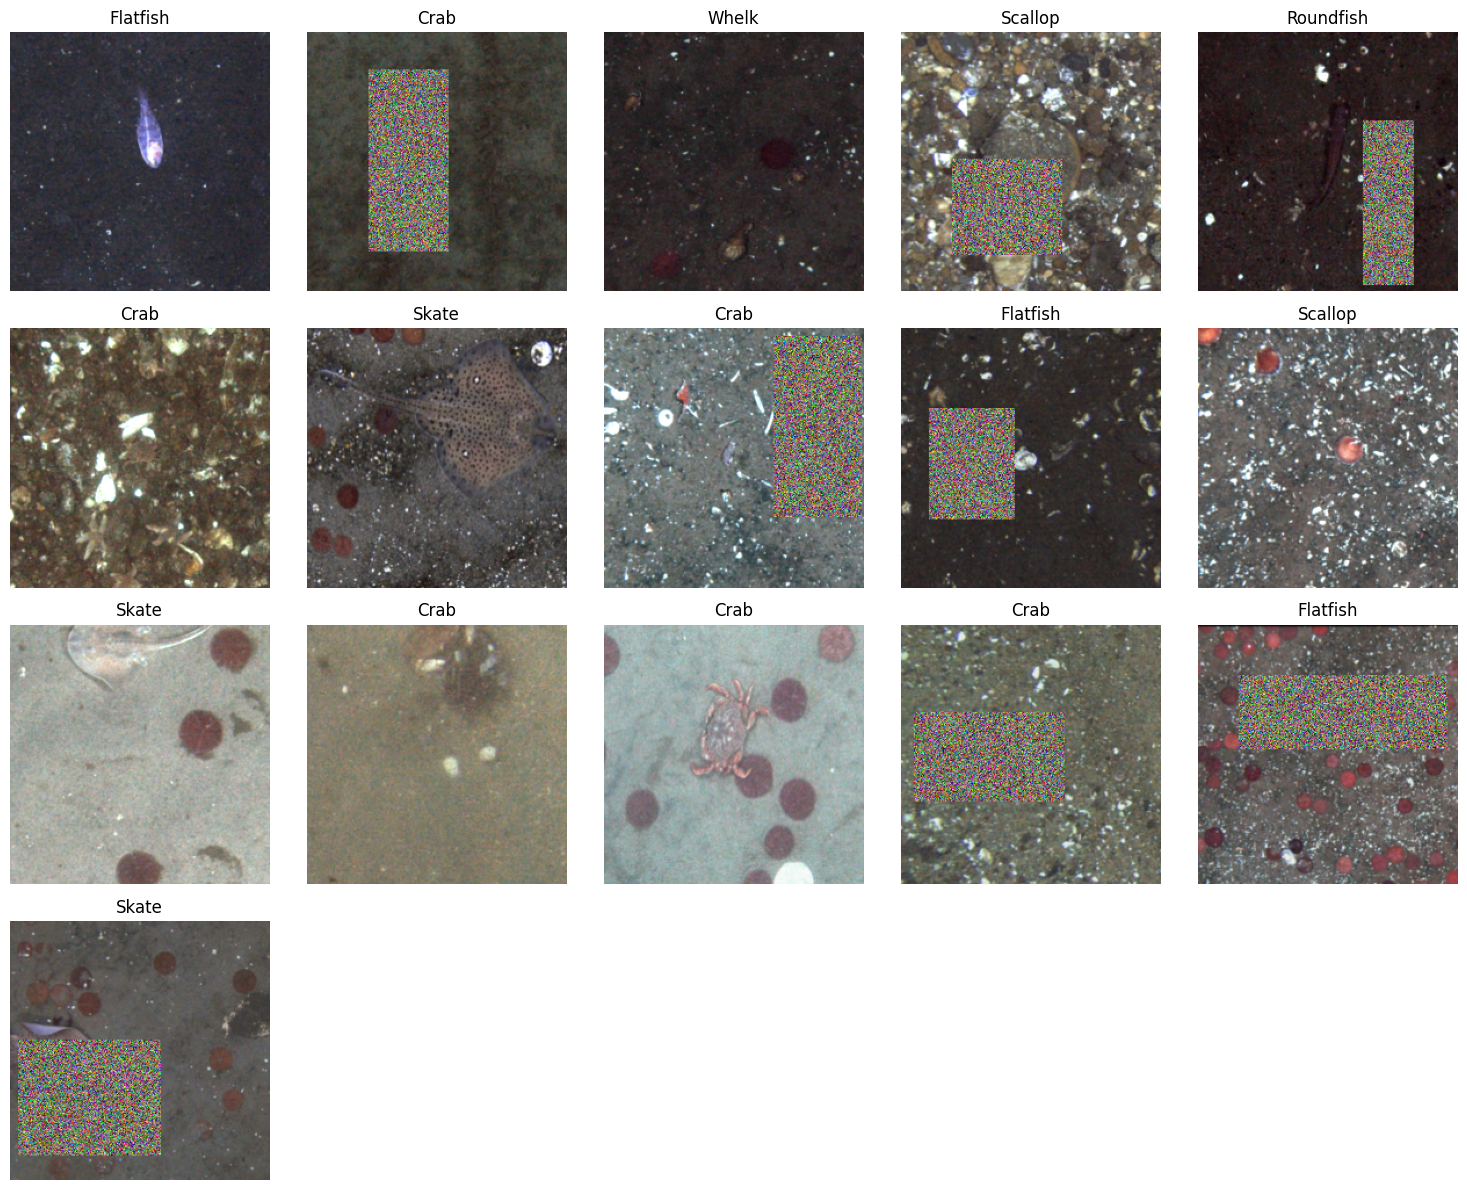

In [ ]:
import matplotlib.pyplot as plt

batch_images, batch_labels = next(iter(train_loader))
inv_norm = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225],
)

cols = 5
rows = math.ceil(batch_images.size(0) / cols)
plt.figure(figsize=(cols * 3, rows * 3))
for idx in range(min(batch_images.size(0), cols * rows)):
    img = inv_norm(batch_images[idx]).clamp(0, 1).permute(1, 2, 0).cpu().numpy()
    label = CLASS_NAMES[batch_labels[idx]]
    ax = plt.subplot(rows, cols, idx + 1)
    ax.imshow(img)
    ax.set_title(label)
    ax.axis("off")
plt.tight_layout()
plt.show()


In [ ]:

import torch
import torch.nn as nn
from torchvision import models
from torchvision.models import DenseNet121_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load ImageNet-pretrained backbone
base_weights = DenseNet121_Weights.IMAGENET1K_V1
model = models.densenet121(weights=base_weights)

# Replace the classifier head to match CLASS_NAMES
in_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(in_features, len(CLASS_NAMES)),
)

# Kaiming-compatible initialization for the new head
head_linear = model.classifier[1]
nn.init.trunc_normal_(head_linear.weight, mean=0.0, std=0.02)
if head_linear.bias is not None:
    nn.init.zeros_(head_linear.bias)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

print(f"Model ready with {len(CLASS_NAMES)} output units.")


Using device: cuda
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 241MB/s]


Model ready with 7 output units.


In [ ]:
# Cell 30: train loop that records history
from tqdm.auto import tqdm

def run_epoch(model, loader, criterion, optimizer=None, device="cpu"):
    is_train = optimizer is not None
    model.train(is_train)

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    loop = tqdm(loader, leave=False)
    for images, labels in loop:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        if is_train:
            optimizer.zero_grad()

        logits = model(images)
        loss = criterion(logits, labels)

        if is_train:
            loss.backward()
            optimizer.step()

        preds = logits.argmax(dim=1)
        total_loss += loss.item() * images.size(0)
        total_correct += (preds == labels).sum().item()
        total_samples += images.size(0)

    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples
    return avg_loss, avg_acc

NUM_EPOCHS = 20
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_acc = run_epoch(model, train_loader, criterion, optimizer, device=device)
    val_loss, val_acc = run_epoch(model, val_loader, criterion, optimizer=None, device=device)

    scheduler.step()

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch:02d} "
          f"| Train Loss: {train_loss:.4f} Acc: {train_acc:.3f} "
          f"| Val Loss: {val_loss:.4f} Acc: {val_acc:.3f}")


  0%|          | 0/460 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 01 | Train Loss: 1.0887 Acc: 0.608 | Val Loss: 0.6432 Acc: 0.781


  0%|          | 0/460 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 02 | Train Loss: 0.7570 Acc: 0.739 | Val Loss: 0.5237 Acc: 0.828


  0%|          | 0/460 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 03 | Train Loss: 0.6456 Acc: 0.785 | Val Loss: 0.4480 Acc: 0.856


  0%|          | 0/460 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 04 | Train Loss: 0.5680 Acc: 0.812 | Val Loss: 0.4289 Acc: 0.858


  0%|          | 0/460 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 05 | Train Loss: 0.5467 Acc: 0.820 | Val Loss: 0.4133 Acc: 0.868


  0%|          | 0/460 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 06 | Train Loss: 0.4689 Acc: 0.838 | Val Loss: 0.3833 Acc: 0.873


  0%|          | 0/460 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 07 | Train Loss: 0.4402 Acc: 0.854 | Val Loss: 0.3818 Acc: 0.881


  0%|          | 0/460 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 08 | Train Loss: 0.4080 Acc: 0.864 | Val Loss: 0.3700 Acc: 0.879


  0%|          | 0/460 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 09 | Train Loss: 0.3750 Acc: 0.877 | Val Loss: 0.3304 Acc: 0.897


  0%|          | 0/460 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.3545 Acc: 0.884 | Val Loss: 0.3440 Acc: 0.893


  0%|          | 0/460 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 11 | Train Loss: 0.3109 Acc: 0.896 | Val Loss: 0.3138 Acc: 0.903


  0%|          | 0/460 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 12 | Train Loss: 0.2975 Acc: 0.900 | Val Loss: 0.3023 Acc: 0.903


  0%|          | 0/460 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 13 | Train Loss: 0.2787 Acc: 0.909 | Val Loss: 0.3227 Acc: 0.901


  0%|          | 0/460 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 14 | Train Loss: 0.2530 Acc: 0.914 | Val Loss: 0.3089 Acc: 0.910


  0%|          | 0/460 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 15 | Train Loss: 0.2467 Acc: 0.920 | Val Loss: 0.2984 Acc: 0.912


  0%|          | 0/460 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 16 | Train Loss: 0.2267 Acc: 0.925 | Val Loss: 0.2931 Acc: 0.911


  0%|          | 0/460 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 17 | Train Loss: 0.2324 Acc: 0.922 | Val Loss: 0.2840 Acc: 0.916


  0%|          | 0/460 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 18 | Train Loss: 0.2136 Acc: 0.929 | Val Loss: 0.2863 Acc: 0.914


  0%|          | 0/460 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 19 | Train Loss: 0.2039 Acc: 0.933 | Val Loss: 0.3072 Acc: 0.911


  0%|          | 0/460 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 20 | Train Loss: 0.2093 Acc: 0.931 | Val Loss: 0.2965 Acc: 0.912


In [ ]:
# Cell A: save the interrupted checkpoint
checkpoint_path = "checkpoint_interrupt.pth"

torch.save(
    {
        "epoch": epoch,                # last completed epoch index (from your loop)
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "history": history,
    },
    checkpoint_path,
)
print(f"Checkpoint saved to {checkpoint_path}")


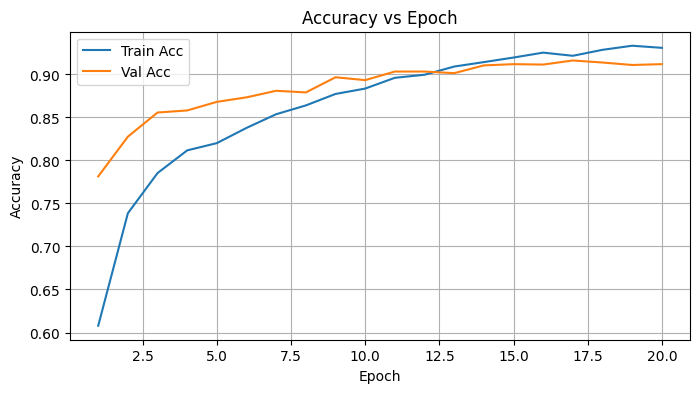

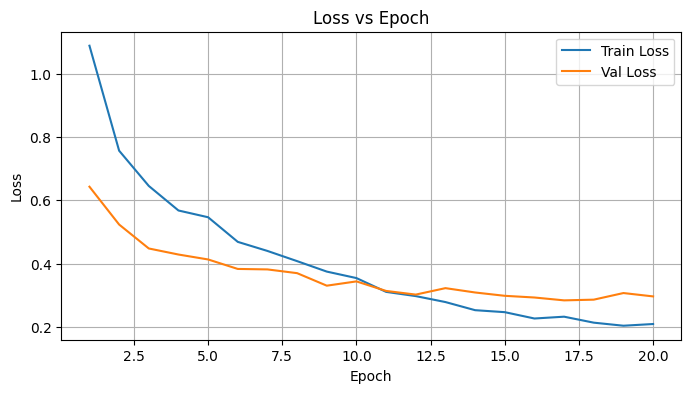

In [ ]:
# Ensure history has the expected keys/lists
assert all(k in history for k in ("train_acc","val_acc","train_loss","val_loss")), "Missing keys in history"

# X-axis as epochs (1..N) so lines align even if you change logging frequency
epochs_acc  = range(1, len(history["train_acc"])  + 1)
epochs_loss = range(1, len(history["train_loss"]) + 1)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(epochs_acc,  history["train_acc"], label="Train Acc")
plt.plot(epochs_acc,  history["val_acc"],   label="Val Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch"); plt.legend(); plt.grid(True)

plt.figure(figsize=(8, 4))
plt.plot(epochs_loss, history["train_loss"], label="Train Loss")
plt.plot(epochs_loss, history["val_loss"],   label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Loss vs Epoch"); plt.legend(); plt.grid(True)

plt.show()

In [ ]:
torch.save(model.state_dict(), "densenet121_benthic_final.pth")


In [ ]:
from google.colab import files
files.download("densenet121_benthic_final.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Evaluate test set but bail out after ~15 minutes (900 s) so the run can’t overrun.
import time
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

MAX_SECONDS = 15 * 60  # 900 seconds
start_time = time.time()

model.eval()
all_labels, all_preds = [], []
processed_images = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device, non_blocking=True)
        logits = model(images)
        preds = logits.argmax(dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        processed_images += images.size(0)

        if time.time() - start_time >= MAX_SECONDS:
            print(f"Stopping early after {processed_images} images (~{int(time.time() - start_time)} s).")
            break
    else:
        print(f"Processed entire loader: {processed_images} images in {time.time() - start_time:.1f} s.")

if not all_labels:
    raise RuntimeError("No samples processed; adjust MAX_SECONDS or ensure test_loader is non-empty.")

print(classification_report(all_labels, all_preds, target_names=CLASS_NAMES, digits=3))

cm = confusion_matrix(all_labels, all_preds, labels=np.arange(len(CLASS_NAMES)))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("DenseNet121 Confusion Matrix (time-limited)")
plt.show()


In [ ]:
from sklearn.metrics import classification_report
report = classification_report(all_labels, all_preds, target_names=CLASS_NAMES, digits=3)
print(report)


In [ ]:
targets = classification_report(
    test_targets.numpy(),
    test_preds.numpy(),
    target_names=CLASS_NAMES,
    output_dict=True,
)

focus = {cls: targets[cls] for cls in ("Crab", "Eel")}
print(json.dumps(focus, indent=2))


In [ ]:
import numpy as np

mis_paths, mis_true, mis_pred = [], [], []
model.eval()
with torch.no_grad():
    for paths, labels in zip(test_loader.dataset.filepaths, test_loader.dataset.labels):
        img = Image.open(paths).convert("RGB")
